<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Defining-the-Hamiltonian" data-toc-modified-id="Defining-the-Hamiltonian-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Defining the Hamiltonian</a></span></li><li><span><a href="#Generating-the-initial-states" data-toc-modified-id="Generating-the-initial-states-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generating the initial states</a></span></li><li><span><a href="#Creating-first-Unitary" data-toc-modified-id="Creating-first-Unitary-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Creating first Unitary</a></span></li><li><span><a href="#Create-First-Objective-Function" data-toc-modified-id="Create-First-Objective-Function-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create First Objective Function</a></span></li><li><span><a href="#First-Optimization-Step" data-toc-modified-id="First-Optimization-Step-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>First Optimization Step</a></span></li><li><span><a href="#Second-Optimization" data-toc-modified-id="Second-Optimization-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Second Optimization</a></span></li></ul></div>

In [22]:
import sys
sys.path.append('../../')

import numpy as np
from qiskit import QuantumCircuit
from qiskit.opflow import I, X, Y, Z
import matplotlib.pyplot as plt

from volta.observables import sample_hamiltonian
from volta.hamiltonians import BCS_hamiltonian

# Defining the Hamiltonian

In [188]:
EPSILONS = [3, 3, 3, 3]
V = -2
hamiltonian = 1 / 2 * (Z ^ I) + 1 / 2 * (Z ^ Z) #BCS_hamiltonian(EPSILONS, V)
print(hamiltonian)

0.5 * ZI
+ 0.5 * ZZ


In [189]:
eigenvalues, _ = np.linalg.eigh(hamiltonian.to_matrix())
print(f"Eigenvalues: {eigenvalues}")

Eigenvalues: [-1.  0.  0.  1.]


# Generating the initial states

In [190]:
def create_circuit(n: int) -> list:
    return [QuantumCircuit(n) for _ in range(2)]

In [191]:
n = hamiltonian.num_qubits
init_states = create_circuit(n)

In [192]:
def copy_unitary(list_states: list) -> list:
    out_states = []
    for state in list_states:
        out_states.append(state.copy())
    return out_states

In [193]:
import textwrap

def apply_initialization(list_states: list) -> None:
    for ind, state in enumerate(list_states):
        b = bin(ind)[2:]
        if len(b) != n:
            b = '0'*(n - len(b)) + b
        spl = textwrap.wrap(b, 1)
        for qubit, val in enumerate(spl):
            if val == '1':
                state.x(qubit)

In [194]:
apply_initialization(init_states)

In [195]:
initialization = copy_unitary(init_states)

# Creating first Unitary

In [196]:
from qiskit.circuit.library import TwoLocal
ansatz = TwoLocal(hamiltonian.num_qubits, ['ry','rz'], 'cx', reps=2)

In [197]:
def apply_ansatz(ansatz: QuantumCircuit, list_states: list) -> None:
    for states in list_states:
        states.append(ansatz, range(n))

In [198]:
apply_ansatz(ansatz, init_states)

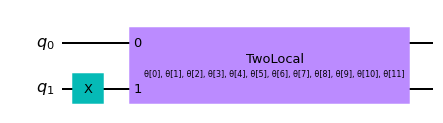

In [199]:
init_states[-1].draw('mpl')

# Create First Objective Function

In [200]:
def _apply_varform_params(ansatz, params: list):
        """Get an hardware-efficient ansatz for n_qubits
        given parameters.
        """
        # Define variational Form
        var_form = ansatz

        # Get Parameters from the variational form
        var_form_params = sorted(var_form.parameters, key=lambda p: p.name)

        # Check if the number of parameters is compatible
        assert len(var_form_params) == len(params), "The number of parameters don't match"

        # Create a dictionary with the parameters and values
        param_dict = dict(zip(var_form_params, params))

        # Assing those values for the ansatz
        wave_function = var_form.assign_parameters(param_dict)

        return wave_function

In [201]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance

def cost_function(params:list) -> float:
        backend = BasicAer.get_backend('qasm_simulator')
        backend = QuantumInstance(backend, shots=10000)
        cost = 0
        
        w = np.arange(len(init_states), 0, -1)
        
        for i, state in enumerate(init_states):
            qc = _apply_varform_params(state, params)

            # Hamiltonian
            hamiltonian_eval = sample_hamiltonian(hamiltonian=hamiltonian, 
                                                 ansatz=qc, 
                                                 backend=backend)
            cost += w[i] * hamiltonian_eval

        return cost

# First Optimization Step

In [202]:
from qiskit.aqua.components.optimizers import COBYLA
optimizer = COBYLA()

In [203]:
n_parameters = len(init_states[0].parameters)

params = np.random.rand(n_parameters)

optimal_params, mean_energy, n_iters = optimizer.optimize(num_vars=n_parameters, 
                                                        objective_function=cost_function, 
                                                        initial_point=params)

In [210]:
mean_energy, sum(eigenvalues[:2])

(-1.9984, -1.0)

In [205]:
# Optimized first ansatz
ansatz_1 = _apply_varform_params(ansatz, optimal_params)
ansatz_1.name = 'U(θ)'

In [206]:
def cost_function_ind(ind: int, params:list) -> float:
        backend = BasicAer.get_backend('qasm_simulator')
        backend = QuantumInstance(backend, shots=10000)
        cost = 0
        
        # Define Ansatz
        qc = _apply_varform_params(init_states[ind], params)

        # Hamiltonian
        hamiltonian_eval = sample_hamiltonian(hamiltonian=hamiltonian, 
                                             ansatz=qc, 
                                             backend=backend)
        cost += hamiltonian_eval

        
        return cost

In [207]:
energies = []
for i in range(len(init_states)):
    energies.append(cost_function_ind(ind=i, params=optimal_params))
energies = np.array(energies)

In [208]:
for i in range(len(init_states)):
    print(f"Value for the {i} state: {energies[i]}\t expected energy {eigenvalues[i]}")

Value for the 0 state: -0.9996	 expected energy -1.0
Value for the 1 state: 0.0004	 expected energy 0.0
